In [1]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pickle
import glob


def load_model(model_path):
    """Load the trained model."""
    print(f"Loading model from {model_path}...")
    model = keras.models.load_model(model_path, compile=False)
    model.summary()
    return model

def preprocess_data(input_file, vars_mli):
    """Preprocess input data for prediction."""
    ds = xr.open_dataset(input_file, engine="netcdf4")
    ds = ds[vars_mli]
    ds["state_t"] = ds["state_t"][0]
    ds["state_q0001"] = ds["state_q0001"][0]
    return ds.stack({"batch": {"ncol"}}).to_stacked_array(
        "mlvar", sample_dims=["batch"], name="mli"
    ).values

def make_predictions(input_file, model, vars_mli, vars_mlo, output_dir):
    """Make predictions and save results."""
    print(f"Processing input file: {input_file}")
    input_data = preprocess_data(input_file, vars_mli)
    predictions = model.predict(input_data)
    return predictions, input_data, vars_mlo

    # Load ground truth
    ds_ground_truth = xr.open_dataset(
        input_file.replace(".mli.", ".mlo."), engine="netcdf4"
    )
    ds_ground_truth = ds_ground_truth[vars_mlo].stack({"batch": {"lev"}}).to_stacked_array(
        "mlvar", sample_dims=["batch"], name="mlo"
    ).values

    # Save predictions and ground truth for comparison
    output_file = os.path.join(output_dir, "predictions_vs_ground_truth.nc")
    print(f"Saving predictions and ground truth to {output_file}")
    xr.Dataset(
        {
            "predictions": (["batch", "mlvar"], predictions_rescaled),
            "ground_truth": (["batch", "mlvar"], ds_ground_truth),
        }
    ).to_netcdf(output_file)

    return predictions_rescaled, ds_ground_truth

def plot_comparison(predictions, ground_truth, vars_mlo, output_dir):
    """Visualize predictions vs ground truth for key variables."""
    for i, var in enumerate(vars_mlo):
        plt.figure(figsize=(12, 8))
        plt.plot(ground_truth[:, i], label=f"Ground Truth ({var})", alpha=0.7)
        plt.plot(predictions[:, i], label=f"Predictions ({var})", alpha=0.7)
        plt.title(f"Comparison: {var}", fontsize=16)
        plt.xlabel("Batch", fontsize=14)
        plt.ylabel(var, fontsize=14)
        plt.legend(fontsize=12)
        plt.grid(True, linestyle="--", alpha=0.6)

        output_file = os.path.join(output_dir, f"comparison_{var}.png")
        plt.savefig(output_file)
        plt.close()
        print(f"Saved comparison plot: {output_file}")
        

2024-11-19 20:29:16.590105: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732066156.640567 1434053 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732066156.657162 1434053 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-19 20:29:16.703286: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
with open("file_list.pkl", "rb") as f:
    all_files = pickle.load(f)
    print("Loaded file list from file_list.pkl.")

# data_file_path = "/home/clarkkam/AIFS/ClimSim/climate-physicsML/data/climsim_lowres_0001-02/datasets--LEAP--ClimSim_low-res/snapshots/bab82a2ebdc750a0134ddcd0d5813867b92eed2a/train/0001-02/" 
data_file_path = "/nfs/turbo/coe-mihalcea/alvarovh/climsim/climsim_all/datasets--LEAP--ClimSim_low-res/snapshots/bab82a2ebdc750a0134ddcd0d5813867b92eed2a/train/0008-02/"
all_files = glob.glob(os.path.join(data_file_path, '*MMF.mli*.nc'))

Loaded file list from file_list.pkl.


In [3]:
all_files


['/nfs/turbo/coe-mihalcea/alvarovh/climsim/climsim_all/datasets--LEAP--ClimSim_low-res/snapshots/bab82a2ebdc750a0134ddcd0d5813867b92eed2a/train/0008-02/E3SM-MMF.mli.0008-02-10-63600.nc',
 '/nfs/turbo/coe-mihalcea/alvarovh/climsim/climsim_all/datasets--LEAP--ClimSim_low-res/snapshots/bab82a2ebdc750a0134ddcd0d5813867b92eed2a/train/0008-02/E3SM-MMF.mli.0008-02-02-18000.nc',
 '/nfs/turbo/coe-mihalcea/alvarovh/climsim/climsim_all/datasets--LEAP--ClimSim_low-res/snapshots/bab82a2ebdc750a0134ddcd0d5813867b92eed2a/train/0008-02/E3SM-MMF.mli.0008-02-08-40800.nc',
 '/nfs/turbo/coe-mihalcea/alvarovh/climsim/climsim_all/datasets--LEAP--ClimSim_low-res/snapshots/bab82a2ebdc750a0134ddcd0d5813867b92eed2a/train/0008-02/E3SM-MMF.mli.0008-02-10-00000.nc',
 '/nfs/turbo/coe-mihalcea/alvarovh/climsim/climsim_all/datasets--LEAP--ClimSim_low-res/snapshots/bab82a2ebdc750a0134ddcd0d5813867b92eed2a/train/0008-02/E3SM-MMF.mli.0008-02-18-58800.nc',
 '/nfs/turbo/coe-mihalcea/alvarovh/climsim/climsim_all/datasets--

In [4]:
files = [0, 500, 1000, 1500, 2000, -1]

In [5]:
input_files = [all_files[i] for i in files]
ground_truths = [file.replace(".mli.", ".mlo.") for file in input_files]

In [6]:
# Define paths
# input_file = all_files[59]
# groundtruth_file = input_file.replace(".mli.", ".mlo.")  # Replace with your .mlo file

# model_path = "/home/clarkkam/AIFS/ClimSim/climate-physicsML/data/DataFraction0.1/output_batch_size_128_learning_rate_0.00001_lambda_0.0/results_0.1/best_model_lambda_0.0_datafrac_0.1_epoch_1.keras"

# model_path = "/home/alvarovh/code/cse598_climate_proj/results/results_0.1/best_model_lambda_0.0_datafrac_0.1_epoch_1.keras"
# output_dir = "/home/clarkkam/AIFS/ClimSim/climate-physicsML/final_combined_loss_model/out_model_figures"  # Replace with your output directory         train_variable_metrics_lambda_0.1_datafrac_0.01.csv
output_dir =  "/home/alvarovh/code/cse598_climate_proj/results_0inindex/out_figures/"
model_path =  "/home/alvarovh/code/cse598_climate_proj/results_0inindex/results_0.01/best_model_lambda_0.1_datafrac_0.01_epoch_1.keras"
model_path = "/home/alvarovh/code/cse598_climate_proj/results_59inindex/results_0.01/best_model_lambda_0.1_datafrac_0.01_epoch_1.keras"
# Variables for input (mli) and output (mlo)
vars_mli = [
    "state_t", "state_q0001", "state_ps", "pbuf_SOLIN", "pbuf_LHFLX", "pbuf_SHFLX", "cam_in_LWUP"
]

vars_mlo = ["state_t","state_q0001",'ptend_t','ptend_q0001','cam_out_NETSW','cam_out_FLWDS','cam_out_PRECSC','cam_out_PRECC','cam_out_SOLS','cam_out_SOLL','cam_out_SOLSD','cam_out_SOLLD']


In [7]:
# Load the trained model
model = load_model(model_path)

Loading model from /home/alvarovh/code/cse598_climate_proj/results_59inindex/results_0.01/best_model_lambda_0.1_datafrac_0.01_epoch_1.keras...


2024-11-19 20:29:21.746171: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "Emulator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 768)            │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 640)            │       492,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       328,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 640)            │       328,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 640)            │       410,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 12)             │         7,692 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 12)             │           156 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,572,904 (6.00 MB)

 Trainable params: 1,572,904 (6.00 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
preds = []
for file in input_files:
    predictions, input_data, vars_mlo = make_predictions(file, model, vars_mli, vars_mlo, output_dir)
    name = file[len(data_file_path):]
    preds.append((predictions, name))

Processing input file: /nfs/turbo/coe-mihalcea/alvarovh/climsim/climsim_all/datasets--LEAP--ClimSim_low-res/snapshots/bab82a2ebdc750a0134ddcd0d5813867b92eed2a/train/0008-02/E3SM-MMF.mli.0008-02-10-63600.nc
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Processing input file: /nfs/turbo/coe-mihalcea/alvarovh/climsim/climsim_all/datasets--LEAP--ClimSim_low-res/snapshots/bab82a2ebdc750a0134ddcd0d5813867b92eed2a/train/0008-02/E3SM-MMF.mli.0008-02-16-55200.nc
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Processing input file: /nfs/turbo/coe-mihalcea/alvarovh/climsim/climsim_all/datasets--LEAP--ClimSim_low-res/snapshots/bab82a2ebdc750a0134ddcd0d5813867b92eed2a/train/0008-02/E3SM-MMF.mli.0008-02-06-66000.nc
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Processing input file: /nfs/turbo/coe-mihalcea/alvarovh/climsim/climsim_all/datasets--LEAP--ClimSim_low-res/snapshots/bab82a2ebdc750a0134ddcd0d5813867b92eed2a/train/0008-02/E3SM-MMF.mli.0008-02-16-16800.nc
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Processing inpu

In [9]:
preds[0][0].shape

(384, 12)

In [10]:
fn_grid = '/home/clarkkam/AIFS/ClimSim/grid_info/ClimSim_low-res_grid-info.nc'
fn_grid = '/home/alvarovh/code/cse598_climate_proj/ClimSim/grid_info/ClimSim_low-res_grid-info.nc'
ds_grid = xr.open_dataset(fn_grid, engine='netcdf4')

In [11]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

def plot_contour_map(lat, lon, values, cmap='viridis', vmin=None, vmax=None, clev=11, title='', save_path=None):
    """
    Plot a contour map with latitude, longitude, and values on a global map.

    Parameters:
    - lat: Array-like, latitude values.
    - lon: Array-like, longitude values.
    - values: Array-like, data values corresponding to lat/lon.
    - cmap: Colormap for the plot. Default is 'viridis'.
    - vmin: Minimum value for the colormap. Default is min(values).
    - vmax: Maximum value for the colormap. Default is max(values).
    - clev: Number of contour levels. Default is 11.
    - title: Title of the plot.
    - save_path: Path to save the plot. If None, the plot is shown interactively.
    """
    # Set up the plot
    fig, ax = plt.subplots(
        subplot_kw={'projection': ccrs.PlateCarree()},
        figsize=(10, 5)
    )
    
    # Set global map features
    ax.set_global()
    ax.coastlines()
    ax.gridlines(draw_labels=True)

    # Handle colormap limits and contour levels
    vmin = vmin if vmin is not None else np.min(values)
    vmax = vmax if vmax is not None else np.max(values)
    clevels = np.linspace(vmin, vmax, clev)

    # Plot the contour map
    contour = ax.tricontourf(
        lon, lat, values, levels=clevels, cmap=cmap, transform=ccrs.PlateCarree()
    )

    # Add colorbar
    cbar = fig.colorbar(contour, ax=ax, orientation='vertical', shrink=0.5, pad=0.05)
    cbar.set_label('Value')

    # Add title
    ax.set_title(title, fontsize=14)

    # Save or show the plot
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    else:
        plt.show()


In [12]:
vars_mlo

['state_t',
 'state_q0001',
 'ptend_t',
 'ptend_q0001',
 'cam_out_NETSW',
 'cam_out_FLWDS',
 'cam_out_PRECSC',
 'cam_out_PRECC',
 'cam_out_SOLS',
 'cam_out_SOLL',
 'cam_out_SOLSD',
 'cam_out_SOLLD']

In [13]:
preds[0][0][:,0]

array([356.53232, 355.275  , 350.65494, 353.7178 , 350.0712 , 346.46658,
       351.18704, 348.35928, 344.76785, 336.9033 , 340.491  , 324.00076,
       333.04385, 338.6486 , 318.90036, 331.3925 , 348.5165 , 352.8132 ,
       351.21768, 352.0721 , 351.2982 , 347.001  , 349.11234, 343.8074 ,
       335.46225, 315.3445 , 334.8135 , 319.97202, 311.2219 , 325.94724,
       311.9108 , 320.91647, 353.70914, 351.29666, 355.22104, 351.39572,
       346.2103 , 338.57248, 344.65115, 332.6484 , 331.07535, 322.04752,
       326.8453 , 324.22006, 314.6382 , 316.77286, 319.90872, 316.9838 ,
       356.56784, 352.30826, 354.80978, 349.47617, 343.6024 , 330.44577,
       342.75058, 335.31802, 328.1572 , 330.86722, 334.05557, 335.8799 ,
       329.2208 , 322.01724, 333.96555, 324.69888, 343.00656, 343.43735,
       339.81943, 343.16867, 343.0991 , 343.15182, 343.93344, 344.43814,
       343.71408, 342.9766 , 344.7206 , 341.84744, 338.53757, 335.51566,
       334.57834, 331.12686, 338.50034, 342.34543, 

In [14]:
state_t_index = 0
preds[0][0][:,state_t_index]

array([356.53232, 355.275  , 350.65494, 353.7178 , 350.0712 , 346.46658,
       351.18704, 348.35928, 344.76785, 336.9033 , 340.491  , 324.00076,
       333.04385, 338.6486 , 318.90036, 331.3925 , 348.5165 , 352.8132 ,
       351.21768, 352.0721 , 351.2982 , 347.001  , 349.11234, 343.8074 ,
       335.46225, 315.3445 , 334.8135 , 319.97202, 311.2219 , 325.94724,
       311.9108 , 320.91647, 353.70914, 351.29666, 355.22104, 351.39572,
       346.2103 , 338.57248, 344.65115, 332.6484 , 331.07535, 322.04752,
       326.8453 , 324.22006, 314.6382 , 316.77286, 319.90872, 316.9838 ,
       356.56784, 352.30826, 354.80978, 349.47617, 343.6024 , 330.44577,
       342.75058, 335.31802, 328.1572 , 330.86722, 334.05557, 335.8799 ,
       329.2208 , 322.01724, 333.96555, 324.69888, 343.00656, 343.43735,
       339.81943, 343.16867, 343.0991 , 343.15182, 343.93344, 344.43814,
       343.71408, 342.9766 , 344.7206 , 341.84744, 338.53757, 335.51566,
       334.57834, 331.12686, 338.50034, 342.34543, 

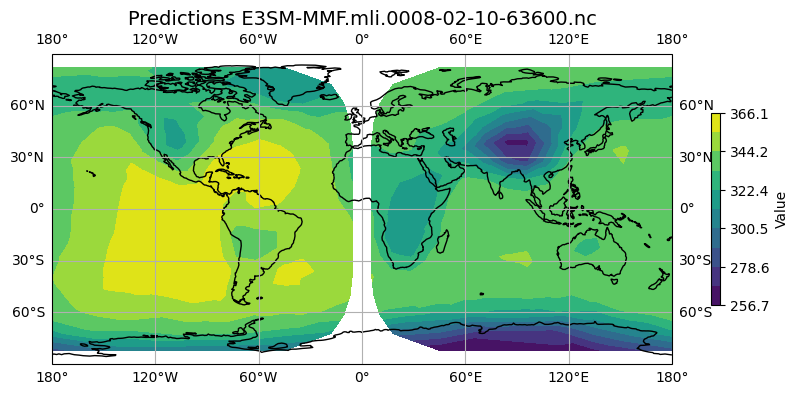

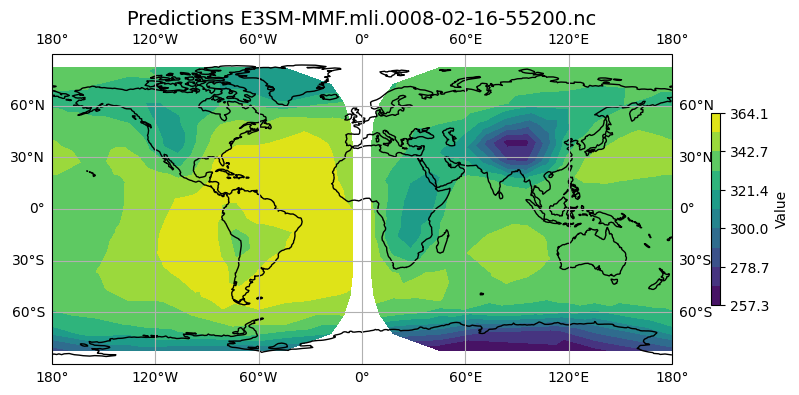

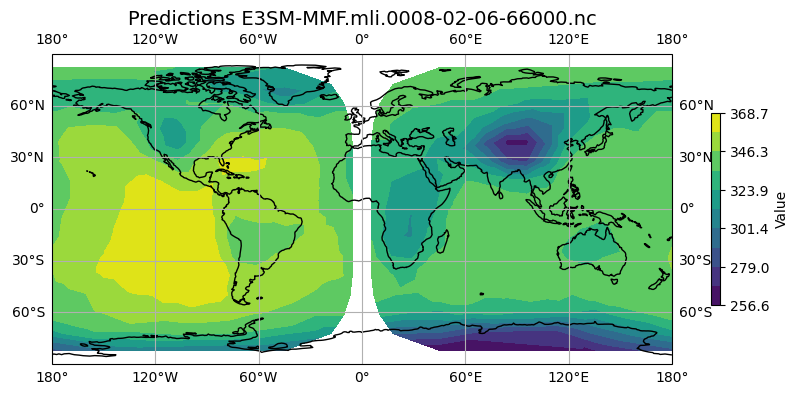

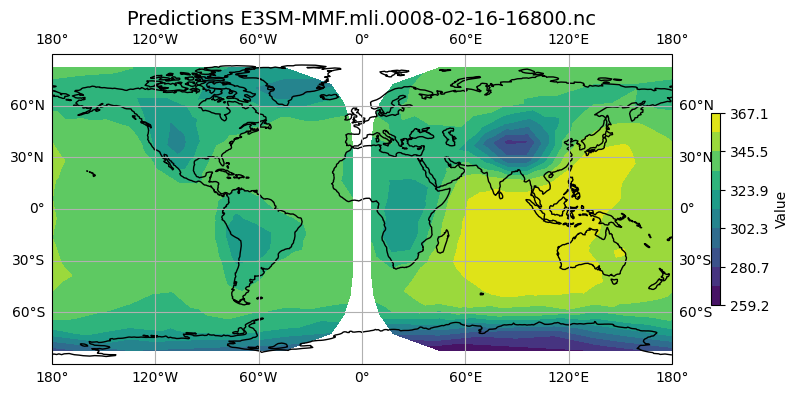

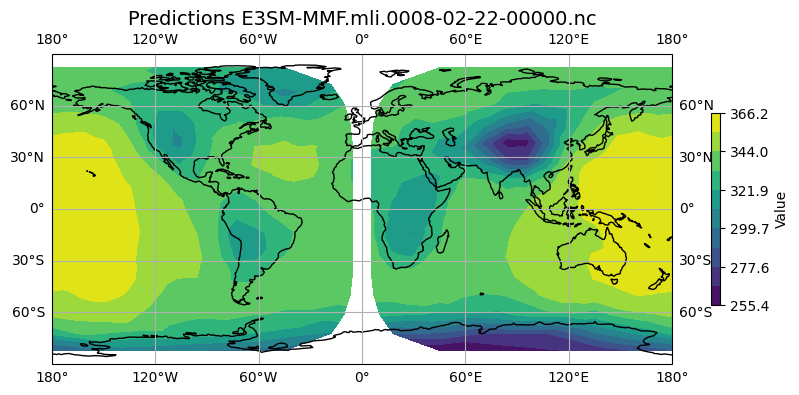

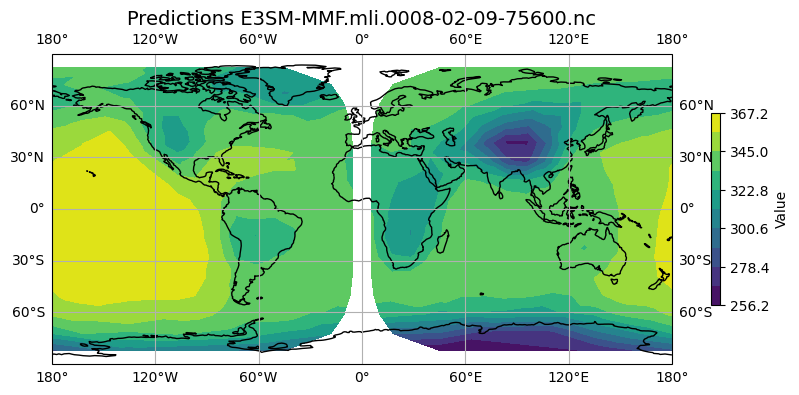

In [15]:
for pred in preds:
    plot_contour_map(ds_grid['lat'], ds_grid['lon'], pred[0][:,state_t_index], title=f"Predictions {pred[1]}")

# Looking at a single day:

In [16]:
os.listdir(data_file_path)

['E3SM-MMF.mlo.0008-02-17-50400.nc',
 'E3SM-MMF.mli.0008-02-10-63600.nc',
 'E3SM-MMF.mli.0008-02-02-18000.nc',
 'E3SM-MMF.mlo.0008-02-24-46800.nc',
 'E3SM-MMF.mli.0008-02-08-40800.nc',
 'E3SM-MMF.mlo.0008-02-11-40800.nc',
 'E3SM-MMF.mlo.0008-02-27-09600.nc',
 'E3SM-MMF.mli.0008-02-10-00000.nc',
 'E3SM-MMF.mli.0008-02-18-58800.nc',
 'E3SM-MMF.mlo.0008-02-03-08400.nc',
 'E3SM-MMF.mlo.0008-02-13-07200.nc',
 'E3SM-MMF.mlo.0008-02-06-56400.nc',
 'E3SM-MMF.mlo.0008-02-12-50400.nc',
 'E3SM-MMF.mlo.0008-02-24-67200.nc',
 'E3SM-MMF.mlo.0008-02-27-22800.nc',
 'E3SM-MMF.mlo.0008-02-28-15600.nc',
 'E3SM-MMF.mlo.0008-02-28-81600.nc',
 'E3SM-MMF.mli.0008-02-18-72000.nc',
 'E3SM-MMF.mli.0008-02-07-24000.nc',
 'E3SM-MMF.mlo.0008-02-05-70800.nc',
 'E3SM-MMF.mlo.0008-02-15-43200.nc',
 'E3SM-MMF.mli.0008-02-19-78000.nc',
 'E3SM-MMF.mlo.0008-02-17-07200.nc',
 'E3SM-MMF.mlo.0008-02-11-57600.nc',
 'E3SM-MMF.mlo.0008-02-07-46800.nc',
 'E3SM-MMF.mli.0008-02-08-00000.nc',
 'E3SM-MMF.mli.0008-02-10-46800.nc',
 

In [17]:
all_files = glob.glob(os.path.join(data_file_path, '*MMF.mli.0008-02-02*.nc'))
all_files = sorted(all_files)
print(len(all_files))


72


In [18]:
num_files = 4
total_files = len(all_files)
step = total_files // num_files
file_indices = [i * step for i in range(num_files)]
file_indices

[0, 18, 36, 54]

In [19]:
all_files

['/nfs/turbo/coe-mihalcea/alvarovh/climsim/climsim_all/datasets--LEAP--ClimSim_low-res/snapshots/bab82a2ebdc750a0134ddcd0d5813867b92eed2a/train/0008-02/E3SM-MMF.mli.0008-02-02-00000.nc',
 '/nfs/turbo/coe-mihalcea/alvarovh/climsim/climsim_all/datasets--LEAP--ClimSim_low-res/snapshots/bab82a2ebdc750a0134ddcd0d5813867b92eed2a/train/0008-02/E3SM-MMF.mli.0008-02-02-01200.nc',
 '/nfs/turbo/coe-mihalcea/alvarovh/climsim/climsim_all/datasets--LEAP--ClimSim_low-res/snapshots/bab82a2ebdc750a0134ddcd0d5813867b92eed2a/train/0008-02/E3SM-MMF.mli.0008-02-02-02400.nc',
 '/nfs/turbo/coe-mihalcea/alvarovh/climsim/climsim_all/datasets--LEAP--ClimSim_low-res/snapshots/bab82a2ebdc750a0134ddcd0d5813867b92eed2a/train/0008-02/E3SM-MMF.mli.0008-02-02-03600.nc',
 '/nfs/turbo/coe-mihalcea/alvarovh/climsim/climsim_all/datasets--LEAP--ClimSim_low-res/snapshots/bab82a2ebdc750a0134ddcd0d5813867b92eed2a/train/0008-02/E3SM-MMF.mli.0008-02-02-04800.nc',
 '/nfs/turbo/coe-mihalcea/alvarovh/climsim/climsim_all/datasets--

In [20]:
input_files = [all_files[i] for i in file_indices]
ground_truths = [file.replace(".mli.", ".mlo.") for file in input_files]
preds = []
for file in input_files:
    predictions, input_data, vars_mlo = make_predictions(file, model, vars_mli, vars_mlo, output_dir)
    name = file[len(data_file_path):]
    preds.append((predictions, name))

Processing input file: /nfs/turbo/coe-mihalcea/alvarovh/climsim/climsim_all/datasets--LEAP--ClimSim_low-res/snapshots/bab82a2ebdc750a0134ddcd0d5813867b92eed2a/train/0008-02/E3SM-MMF.mli.0008-02-02-00000.nc
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Processing input file: /nfs/turbo/coe-mihalcea/alvarovh/climsim/climsim_all/datasets--LEAP--ClimSim_low-res/snapshots/bab82a2ebdc750a0134ddcd0d5813867b92eed2a/train/0008-02/E3SM-MMF.mli.0008-02-02-21600.nc
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Processing input file: /nfs/turbo/coe-mihalcea/alvarovh/climsim/climsim_all/datasets--LEAP--ClimSim_low-res/snapshots/bab82a2ebdc750a0134ddcd0d5813867b92eed2a/train/0008-02/E3SM-MMF.mli.0008-02-02-43200.nc
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Processing input file: /nfs/turbo/coe-mihalcea/alvarovh/climsim/climsim_all/datasets--LEAP--ClimSim_low-res/snapshots/bab82a2ebdc750a0134ddcd0d5813867b92eed2a/train/0008-02/E3SM-MMF.mli.0008-02-02-64800.nc
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


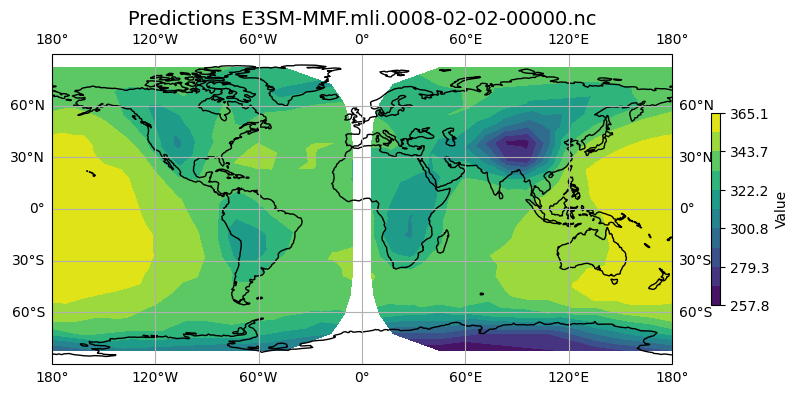

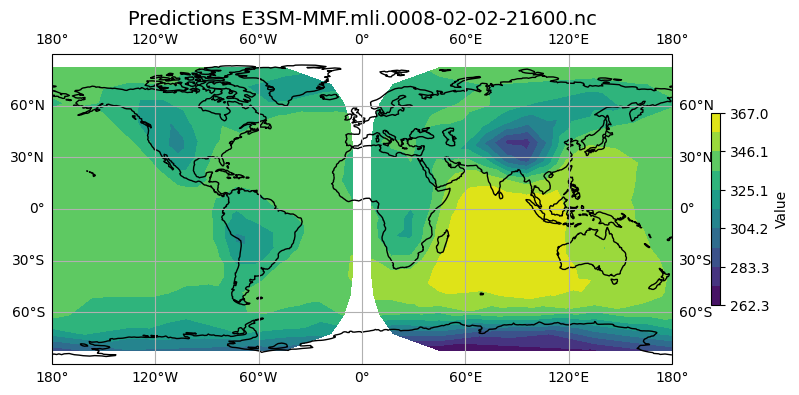

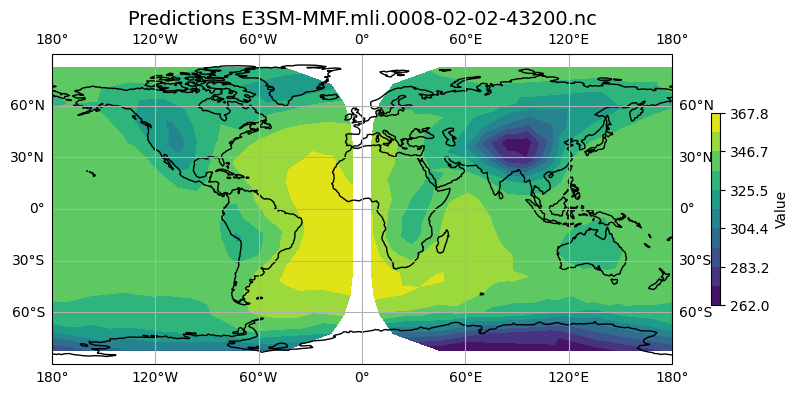

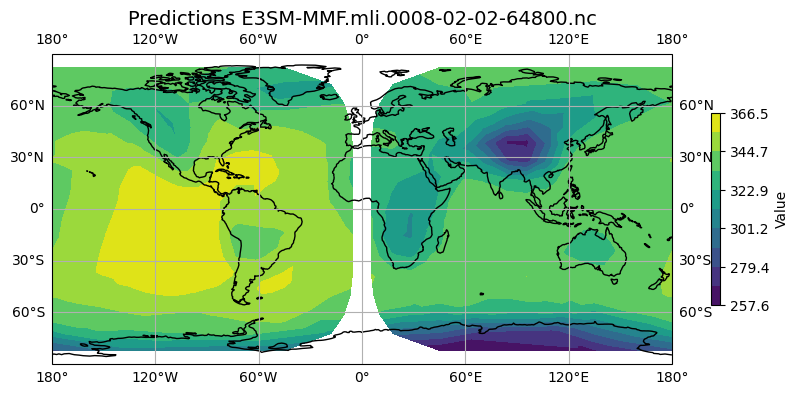

In [21]:
for pred in preds:
    plot_contour_map(ds_grid['lat'], ds_grid['lon'], pred[0][:,state_t_index], title=f"Predictions {pred[1]}")

# Looking at error now:

In [22]:
# ground_truth_data = []
# for file in ground_truths:
file = ground_truths[0]
dso = xr.open_dataset(file, engine="netcdf4")
ds = xr.open_dataset(file.replace('.mlo.', '.mli.'), engine='netcdf4')
ds = ds[vars_mli]
# ds["state_t"] = ds["state_t"][59]




In [23]:
ds["state_t"][59]

<xarray.DataArray 'state_t' (ncol: 384)> Size: 3kB
[384 values with dtype=float64]
Dimensions without coordinates: ncol

In [24]:
ds["state_t"][59].values

array([296.07817424, 292.72829698, 298.73755031, 297.71867414,
       291.57410872, 289.30955461, 297.65787621, 294.88247328,
       285.77841503, 288.35241682, 294.34393599, 298.76743642,
       293.02007674, 293.57589364, 294.93723393, 297.49235349,
       296.62026197, 297.42794392, 299.34282189, 298.0899775 ,
       297.37965273, 295.71814487, 299.11682098, 298.57952576,
       296.54355288, 302.19798693, 299.39986418, 301.96227357,
       294.79339016, 299.58292085, 299.72607756, 300.28338525,
       298.72635139, 299.24356434, 297.03216979, 296.08327595,
       302.11330458, 302.42718234, 295.0205907 , 290.99231945,
       301.03686924, 299.80257665, 288.69858942, 288.75047334,
       303.30401586, 299.56822185, 297.92256788, 299.49528815,
       295.08246984, 292.71358855, 290.55057817, 290.42246196,
       289.59407611, 282.80389842, 287.48719064, 282.24036778,
       279.29371705, 280.13179985, 278.95548325, 278.03858045,
       287.5641774 , 295.21722159, 279.02085448, 286.09

In [25]:
ds["state_t"].values

array([[216.58739446, 216.10842438, 217.75597177, ..., 215.04454188,
        218.30075272, 218.97397211],
       [226.36848882, 223.00093235, 235.97855925, ..., 225.04960565,
        236.38606765, 231.89649362],
       [230.45634064, 227.70292415, 234.72316989, ..., 235.43455903,
        242.10254578, 238.1762398 ],
       ...,
       [294.6957797 , 290.99843937, 296.82702493, ..., 255.60011023,
        265.58603259, 266.55410229],
       [295.3820606 , 291.84689294, 297.81770593, ..., 256.34730634,
        266.71235088, 267.68281167],
       [296.07817424, 292.72829698, 298.73755031, ..., 257.2188324 ,
        267.90646955, 268.90299971]])

In [26]:
ground_truth_data = []
for file in ground_truths:
    dso = xr.open_dataset(file, engine="netcdf4")
    ds = xr.open_dataset(file.replace('.mlo.', '.mli.'), engine='netcdf4')
    ds = ds[vars_mli]
    ds["state_t"] = ds["state_t"][59]
    ds["state_q0001"] = ds["state_q0001"][59]

    dso['ptend_t'] = (dso['state_t'] - ds['state_t']) / 1200  # T tendency [K/s]
    dso['ptend_q0001'] = (dso['state_q0001'] - ds['state_q0001']) / 1200  # Q tendency [kg/kg/s]
    dso = dso[vars_mlo]
    dso['state_t'] = dso['state_t'][59]
    dso['state_q0001'] = dso['state_q0001'][59]
    dso['ptend_t'] = dso['ptend_t'][59]
    dso['ptend_q0001'] = dso['ptend_q0001'][59]
    dso = dso.stack({"batch": {"ncol"}}).to_stacked_array(
        "mlvar", sample_dims=["batch"], name="mli"
    ).values 
    ground_truth_data.append(dso)
ground_truth_data[0][:,state_t_index]

array([296.02913329, 292.70366929, 298.69039448, 297.64362281,
       291.56312727, 289.27725466, 297.62541628, 294.83287841,
       285.68312978, 288.19852244, 294.29402164, 298.69140493,
       292.88719808, 293.49585238, 294.79219033, 297.25528487,
       296.27516859, 297.24268122, 299.27852418, 297.99020083,
       297.33761757, 295.68255292, 299.08047977, 298.55615431,
       296.4838997 , 302.12325141, 299.35969566, 302.02295569,
       294.60909246, 299.54475255, 299.68970995, 300.24669453,
       298.60848045, 299.1905181 , 296.94083973, 296.04675651,
       302.06198035, 302.39605703, 294.98805491, 290.96897228,
       300.98582   , 299.8312755 , 288.62547487, 288.6667544 ,
       303.23103613, 299.48538564, 297.91739368, 299.42219124,
       294.90681245, 292.62703426, 290.60578599, 290.38485553,
       289.58676897, 282.73367654, 287.39264982, 282.19069528,
       279.27330744, 280.08036183, 278.92784505, 278.00006407,
       287.53290954, 295.19789336, 278.99694606, 286.06

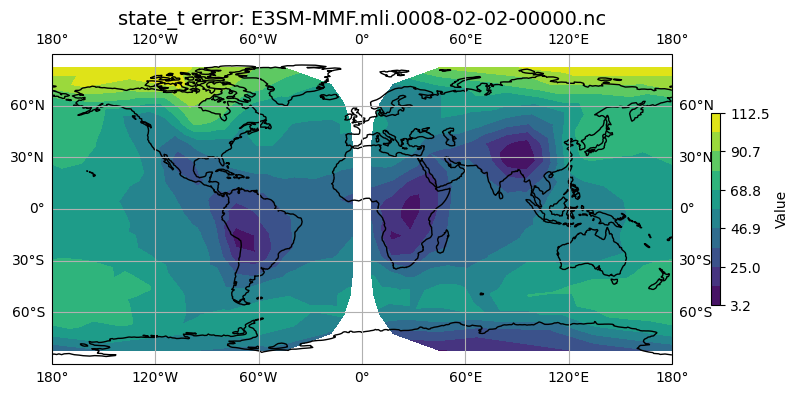

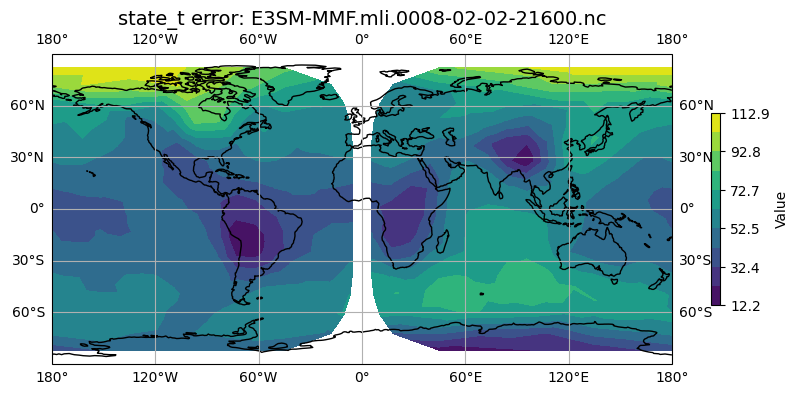

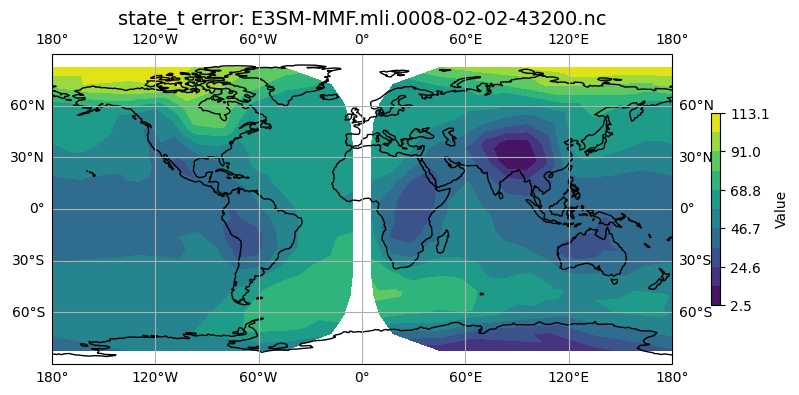

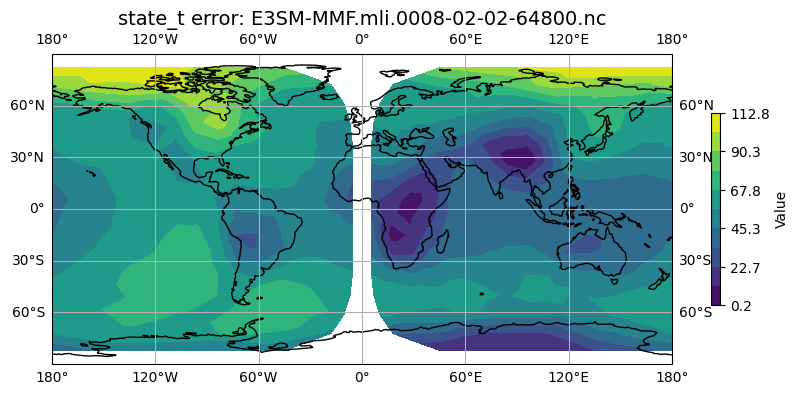

In [29]:
for index, pred in enumerate(preds):
    plot_contour_map(ds_grid['lat'], ds_grid['lon'], abs(pred[0][:,state_t_index] - ground_truth_data[index][:,state_t_index]), title=f"state_t error: {pred[1]}")

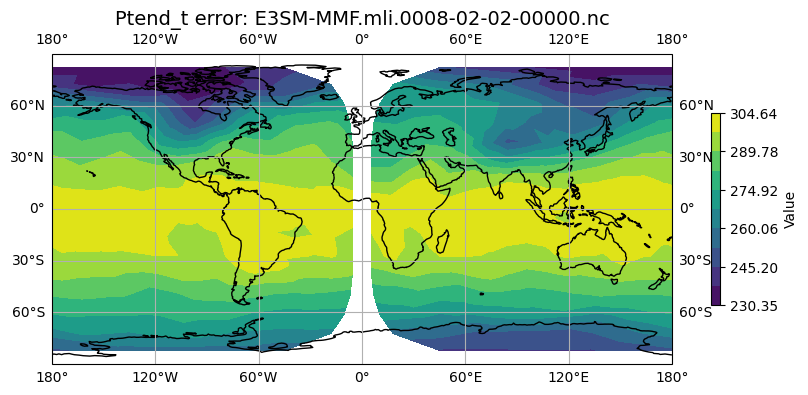

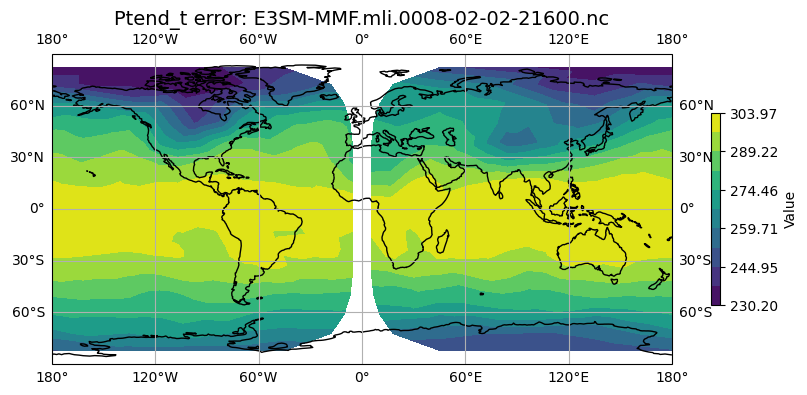

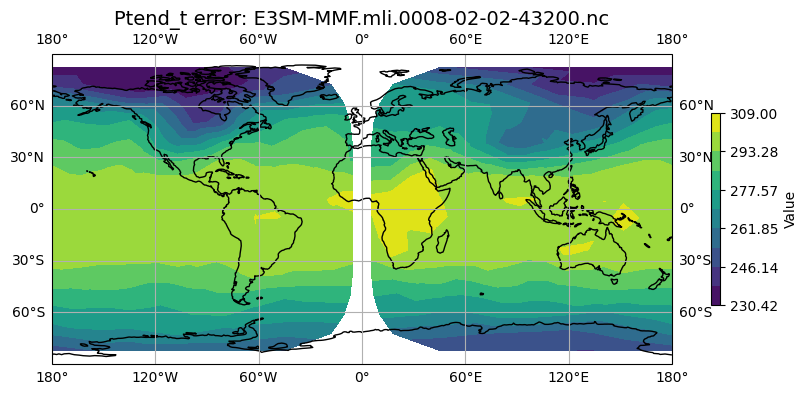

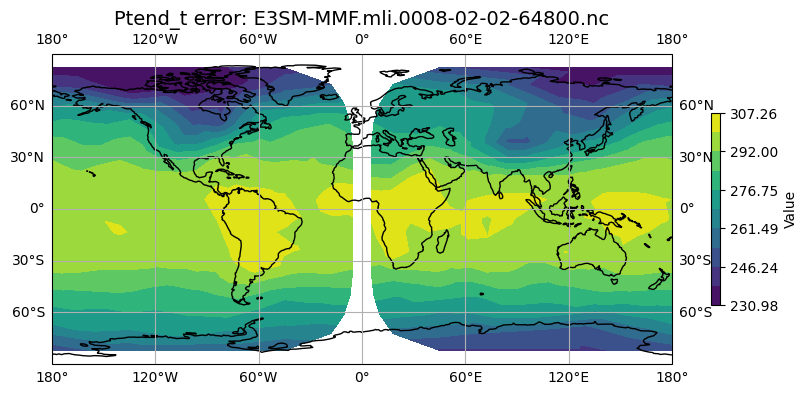

In [28]:
for index, pred in enumerate(preds):
    plot_contour_map(ds_grid['lat'], ds_grid['lon'], ground_truth_data[index][:,state_t_index], title=f"Ptend_t error: {pred[1]}")